### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from glob import glob 
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context='paper', color_codes=False)

sys.path.insert(0,"../")
from plotGraphs import *
from MLpipelines.plotResults import *
from imagen_dataloader import *
# from niwidgets import NiftiWidget

In [3]:
# Specify the path to the data
DATA_DIR = "/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/"
BIDS_DIR = "/ritter/share/data/IMAGEN/IMAGEN_BIDS/"
H5_DIR = "/ritter/share/data/IMAGEN/h5files/"

In [4]:
# path to questionaires files
qs = dict(
        AUDIT_BL  = DATA_DIR + "BL/psytools/IMAGEN-IMGN_AUDIT_CHILD_RC5-IMAGEN_DIGEST.csv",
        AUDIT_FU1 = DATA_DIR + "FU1/psytools/IMAGEN-IMGN_AUDIT_CHILD_FU_RC5-IMAGEN_DIGEST.csv",
        AUDIT_FU2 = DATA_DIR + "FU2/psytools/IMAGEN-IMGN_AUDIT_CHILD_FU2-IMAGEN_DIGEST.csv",
        AUDIT_FU3 = DATA_DIR + "FU3/psytools/IMAGEN-IMGN_AUDIT_FU3.csv",
        ESPAD_BL  = DATA_DIR + "BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv",
        ESPAD_FU1 = DATA_DIR + "FU1/psytools/IMAGEN-IMGN_ESPAD_CHILD_FU_RC5-IMAGEN_DIGEST.csv",
        ESPAD_FU2 = DATA_DIR + "FU2/psytools/IMAGEN-IMGN_ESPAD_CHILD_FU2-IMAGEN_DIGEST.csv",
        ESPAD_FU3 = DATA_DIR + "FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv",
          
        AUDIT_GM       = DATA_DIR + "growthcurves/AUDIT/IMGN_AUDITtotal_GM.csv",
        AUDIT_GM_FINE  = DATA_DIR + "growthcurves/AUDIT/IMGN_AUDITtotal_GM_FINE.csv",
        ESPAD_GM       = DATA_DIR + "growthcurves/ESPAD/IMGN_ESPAD19b_GM.csv",
        ESPAD_GM_FINE  = DATA_DIR + "growthcurves/ESPAD/IMGN_ESPAD19b_GM_FINE.csv",
        
        PHENOTYPE = DATA_DIR + "combinations/drinking_phenotype/Seo_drinking_phenotype_fu2.csv",
        )

### Create h5 with random confs


In [5]:
# attach random confs to an h5 file
H5_FILES = {
    "h5causal0" : "newlbls-clean-bl-espad-fu3-19a-binge-causal-onset0-n477.h5",
    "h5causal1" : "newlbls-clean-bl-espad-fu3-19a-binge-causal-onset1-n565.h5",
    # Take the 3 h5files used in paper
    "h5fu3" : "newlbls-clean-fu3-espad-fu3-19a-binge-n650.h5",
    "h5fu2" : "newlbls-clean-fu2-espad-fu3-19a-binge-n634.h5",
    "h5bl" : "newlbls-clean-bl-espad-fu3-19a-binge-n620.h5",
}
# h5_name = "h5causal0"
# h5_filename = H5_FILES[h5_name]
# n_permutes = 10000
# RAND_STATE = 42

# # create a copy of the selected h5 file first
# out_h5 = f"permutedconfs{n_permutes}-{h5_filename}"
# print("writing to ..", out_h5)

# with h5py.File("h5_permuted_confs/"+out_h5, 'w') as data_out:

#     with h5py.File(H5_DIR + h5_filename, 'r') as data_src:
#         n = len(data_src['X'])
#         for dataset in data_src:
#             data_out.create_dataset(dataset, data=data_src[dataset]) 
#         for attr in data_src.attrs:
#             data_out.attrs[attr]=data_src.attrs[attr]
            
#         # add randomly permuted binary variables as confs
#         np.random.seed(RAND_STATE)
#         rand_confs = np.random.randint(0,2,size=(n_permutes, n))
#         for i,rand_conf in enumerate(rand_confs):
#             data_out.create_dataset(f"dummy_{i}", data=rand_conf) 
        

In [36]:
# # verify
# with h5py.File("h5_permuted_confs/"+out_h5, 'r') as data_out:
#     print(f"n={len(data_out['X'])}")
#     print(f"keys = {list(data_out.keys())}")
#     print(f"attrs keys = {list(data_out.attrs.keys())}")

### Run analysis
1. Add the above h5 file in the pipeline `runMLpipelines_permuteconfs.py` 
2. adjust the settings such as `PERMUTE_CONFS`, `PERMUTE_CONFS_N`,`BINARIZE_ALL_EXPERIMENT` etc
3. Move the file `runMLpipelines_permuteconfs.py` to the ../MLpipelines directory
4. Run `! nohup python3 runMLpipelines_permuteconfs.py &> nohup.out &`

### Plot results

#### Random confounds

In [92]:
from matplotlib.lines import Line2D
from scipy.stats import describe
import json

def plot_dists(df_ccs, df_true, sharey=True, 
               ylabel='', print_stats=False, only_models=[],
               save_results=''):
    n_models = 4 if not only_models else len(only_models)
    fig, axes = plt.subplots(len(df_ccs), n_models, sharex=True, sharey=sharey, 
                             figsize=(4*n_models,4*len(df_ccs)))
    
    #store all results in a dict
    results = {}
    for i, df_cc_path in enumerate(df_ccs):
        df_cc = pd.read_csv(glob(df_cc_path)[-1])
        axes_row = axes[i] if len(df_ccs)>1 else axes
        # draw legend
        custom_lines = [Line2D([0], [0], color="tab:blue", markerfacecolor="tab:blue", 
                               marker='o', markersize=5, lw=0),
                        Line2D([0], [0], color="tab:red", lw=1, linestyle="--"),
                        Line2D([0], [0], color="k", lw=1),]

        axes_row[0].legend(custom_lines, ['after controlling', 
                                          'before controlling'], loc='upper left')
        if not ylabel:
            ylabel = "confounds ="
            ylabel += df_cc_path.split("permuteconfs-")[-1][:2] + ' random'
            if 'excludingsexsite' not in df_cc_path: ylabel += '+ [sex, site]'
        axes_row[0].set_ylabel(ylabel)
        k=0
        
        for j, (model, dfi) in enumerate(df_cc.groupby('model')):
            if (not only_models) or (model in only_models):
                ax = axes_row[k]
                k+=1
                model_scores = df_true.loc[(df_true.model == model) & (df_true.technique=='cb'), 'test_score']
                random_scores = dfi['test_score']
                ax.hist(random_scores, bins='auto', alpha=0.8)
                if print_stats:
                    print(model,"\n", "-"*10)
                    print("permuted distribution statistics:\n", describe(random_scores))
                    print("(-2*std, -1*std, mean, +1*std, +2*std): ({:.2f},{:.2f},{:.2f},{:.2f},{:.2f})".format(
                        np.mean(random_scores)-2*np.std(random_scores), np.mean(random_scores)-1*np.std(random_scores),
                        np.mean(random_scores),
                        np.mean(random_scores)+2*np.std(random_scores), np.mean(random_scores)+1*np.std(random_scores),))
                
                # save the rand run results 
                results.update({model:{'model_scores': list(model_scores), 
                                               'random_scores': list(random_scores)}})
                    
                for score in model_scores:
                    ax.axvline(score, color="tab:red", lw=1, linestyle="--")

                if i==0: ax.set_title(f"model = {model}")

                # chance line
                ax.axvline(0.5, color="k", lw=1)

                if i==len(df_ccs)-1: ax.set_xlabel("Balanced accuracy (%)")
    
    if save_results:
        # Writing to permutation_results.json in given save_results dir
        with open(save_results+"permutation_results.json", "w") as outfile:
            json_object = json.dumps(results, indent=4)
            outfile.write(json_object)

Is it enough to use n=100 random confs to capture the distribution?<br>
Compare distribution when  n=100 and n=500<br>

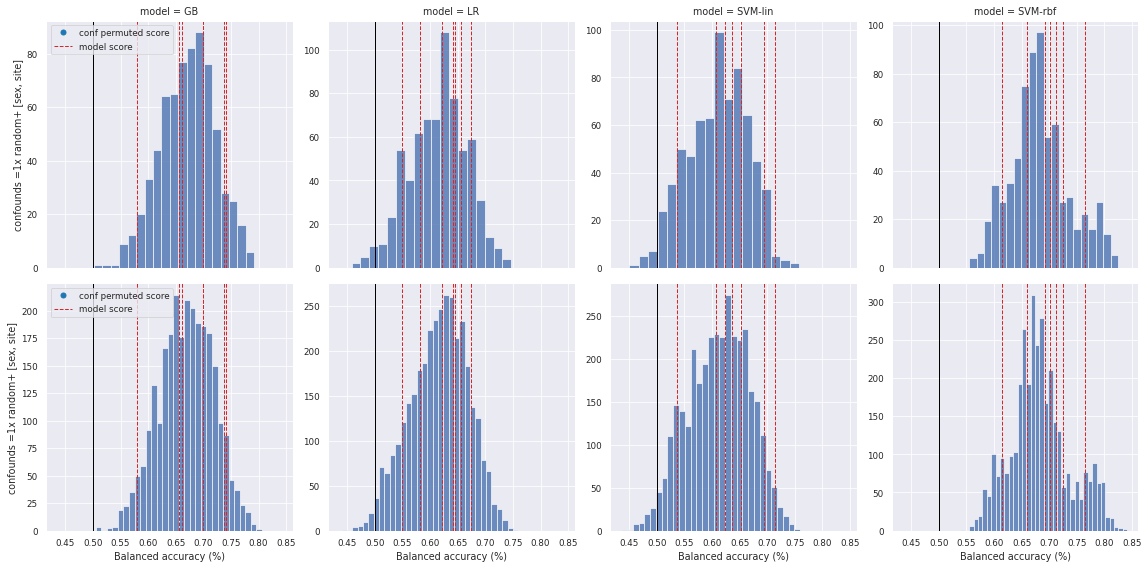

In [47]:
df_ccs = [
    "results/permuteconfs-1x100-fu3/*/run.csv",  
    "results/permuteconfs-1x500-fu3/*/run.csv",  
]


plot_dists(df_ccs, df_true, sharey=False)        
# plt.suptitle(f"Effects of controlling for N random confounds at once:")
plt.tight_layout()
plt.show()

What happens when we iteratively add more random confs to the analysis?

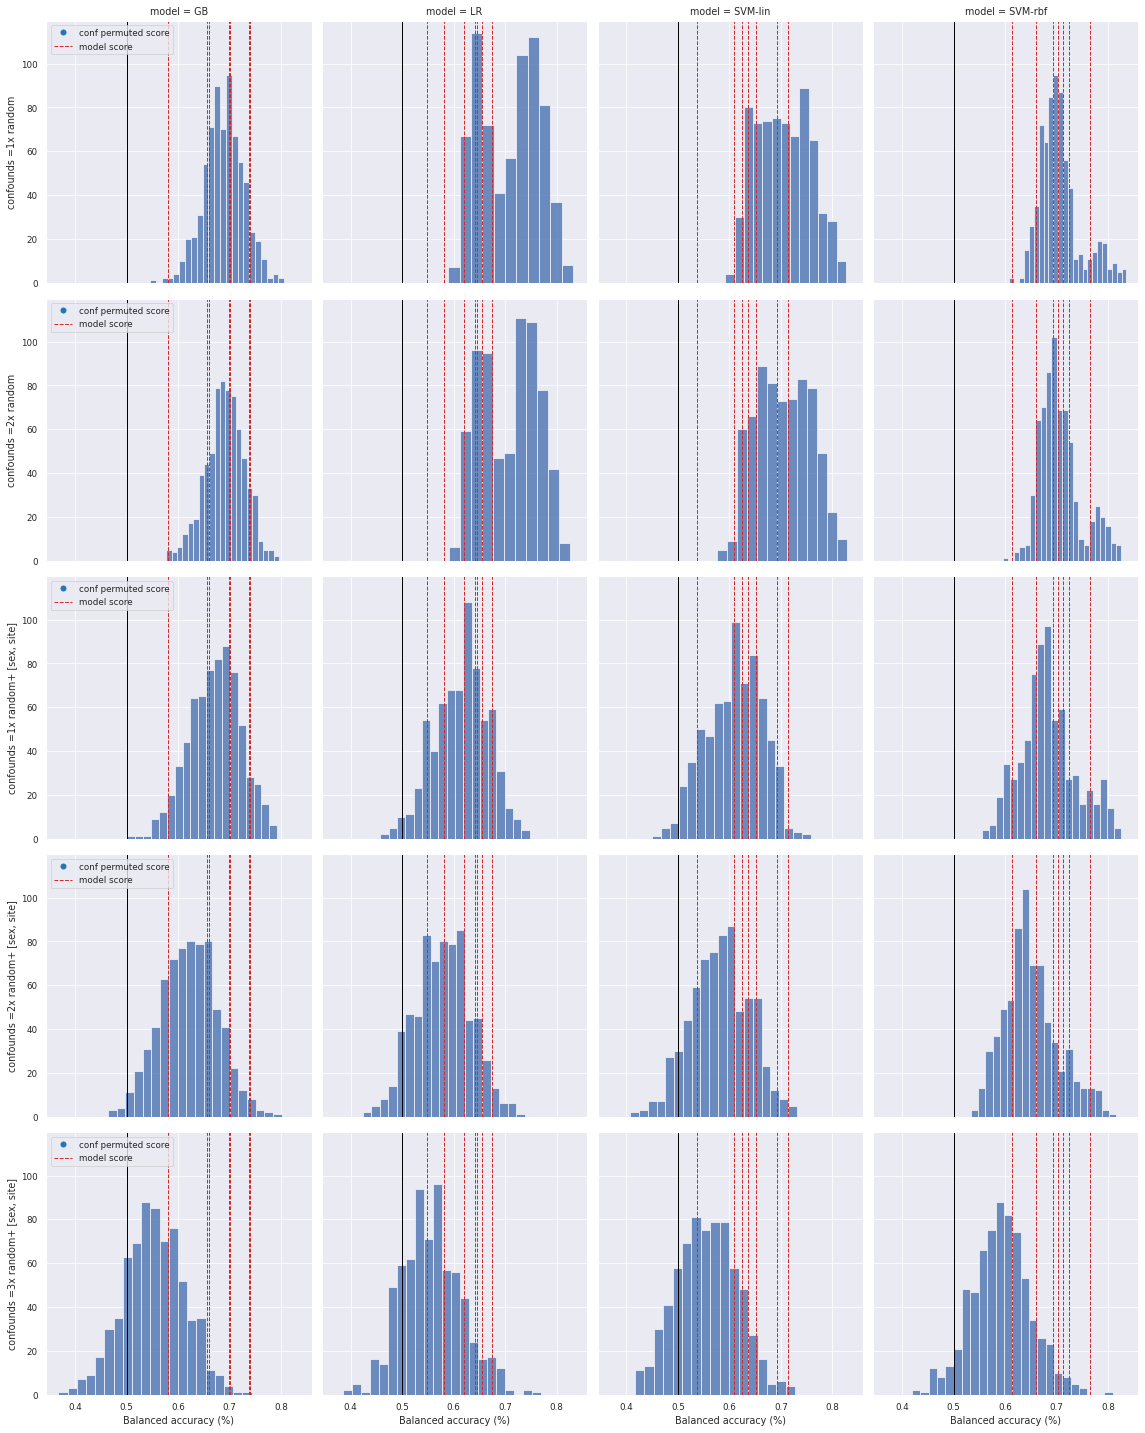

In [60]:
df_ccs = [
    "results/permuteconfs-1x100-fu3-excludingsexsite/*/run.csv",  
    "results/permuteconfs-2x100-fu3-excludingsexsite/*/run.csv",  
    "results/permuteconfs-1x100-fu3/*/run.csv",  
    "results/permuteconfs-2x100-fu3/*/run.csv",  
    "results/permuteconfs-3x100-fu3/*/run.csv",
]


plot_dists(df_ccs, df_true)        
# plt.suptitle(f"Effects of controlling for N random confounds at once:")
plt.tight_layout()
# plt.savefig("Effects of controlling for N random confounds at once")

#### Random confounds BL

GB 
 ----------
permuted distribution statistics:
 DescribeResult(nobs=3500, minmax=(0.4908424908424908, 0.8133208255159474), mean=0.6539790857806537, variance=0.0028654848193419287, skewness=0.0356270026541063, kurtosis=-0.35053281861066976)
(-2*std, -1*std, mean, +1*std, +2*std): (0.55,0.60,0.65,0.76,0.71)
SVM-rbf 
 ----------
permuted distribution statistics:
 DescribeResult(nobs=3500, minmax=(0.5293040293040293, 0.7890243902439025), mean=0.6705094593559751, variance=0.001843946984950436, skewness=-0.2870617499670912, kurtosis=-0.2106394534427194)
(-2*std, -1*std, mean, +1*std, +2*std): (0.58,0.63,0.67,0.76,0.71)


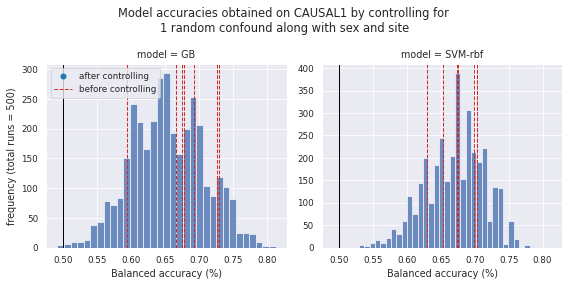

GB 
 ----------
permuted distribution statistics:
 DescribeResult(nobs=3500, minmax=(0.4166666666666667, 0.8663194444444444), mean=0.6420999817501833, variance=0.003847223517153156, skewness=0.04287737209212217, kurtosis=-0.20434751323373046)
(-2*std, -1*std, mean, +1*std, +2*std): (0.52,0.58,0.64,0.77,0.70)
SVM-rbf 
 ----------
permuted distribution statistics:
 DescribeResult(nobs=3500, minmax=(0.46875, 0.8072916666666667), mean=0.6393977690247851, variance=0.003084088701488275, skewness=-0.04798402493329343, kurtosis=-0.6464624361510034)
(-2*std, -1*std, mean, +1*std, +2*std): (0.53,0.58,0.64,0.75,0.69)


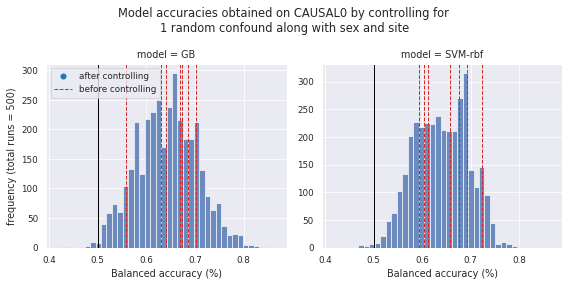

GB 
 ----------
permuted distribution statistics:
 DescribeResult(nobs=3500, minmax=(0.5264660093409445, 0.8086890243902439), mean=0.6753289736081253, variance=0.0017908069685617647, skewness=-0.09115703625729212, kurtosis=-0.25475449056239396)
(-2*std, -1*std, mean, +1*std, +2*std): (0.59,0.63,0.68,0.76,0.72)
SVM-rbf 
 ----------
permuted distribution statistics:
 DescribeResult(nobs=3500, minmax=(0.5233739837398375, 0.782520325203252), mean=0.6815178416981739, variance=0.0012920120837821517, skewness=-0.5207484265503131, kurtosis=0.1125253628750964)
(-2*std, -1*std, mean, +1*std, +2*std): (0.61,0.65,0.68,0.75,0.72)


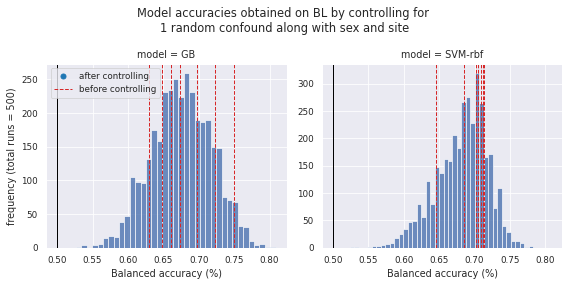

In [93]:
for h5_name in ["h5causal1", "h5causal0", "h5bl"]: # "h5bl"
    
    df_true = pd.read_csv(glob(f"../MLpipelines/results/{H5_FILES[h5_name].replace('.h5','')}/*/run.csv")[0])
    df_cc = f"results/permuteconfs-1x500-{h5_name.replace('h5','')}/*/run.csv"

    plot_dists([df_cc], df_true, 
               sharey=False, 
               ylabel='frequency (total runs = 500)', 
               print_stats=True,
               only_models=['SVM-rbf', 'GB'],
               save_results=f"results/{h5_name}_")        
    plt.suptitle(f"Model accuracies obtained on {h5_name.replace('h5','').upper()} by controlling for \n1 random confound along with sex and site")
    plt.tight_layout()
    plt.show()

#### Binarizing boundaries

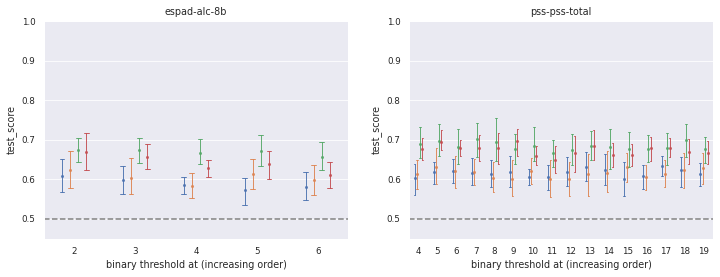

In [24]:
f, axes = plt.subplots(1,2, figsize=(12,4))

for i, bin_exp in enumerate(glob("results/binarizeall-*/*/run.csv")):
    var_name = bin_exp.split('/')[-3].replace("binarizeall-posthoc-cc-fu3-", '').replace('-binarize-all-n650','')
    
    df_bin = pd.read_csv(bin_exp)
    df_bin['confs'] = [int(eval(lst)[-1].replace(var_name,'').replace('t','')) for lst in df_bin['confs']]
    
    # plotting details
    palette = sns.color_palette()
    ci, dodge, scale, errwidth, capsize = 95, 0.4, 0.4, 0.9, 0.08  
    ML_MODELS = ["LR", "SVM-lin", "SVM-rbf", "GB"]
    hue_order= [m for m in ML_MODELS if m in df_bin.model.unique()]
    if len(hue_order)==0: hue_order=None
        
    sns.pointplot(y='test_score', x='confs', data=df_bin, order=np.sort(df_bin['confs'].unique()), 
                  hue="model", hue_order=hue_order, join=False, 
                  ax=axes[i], 
                  ci=ci, errwidth=errwidth, capsize=capsize,
                  dodge=dodge, scale=scale, palette=palette)
    
    axes[i].set_xlabel('binary threshold at (increasing order)')
    axes[i].set_title(var_name)
    axes[i].axhline(y=0.5, label="chance", c='gray', ls='--', lw=1.5)
    axes[i].set_ylim(0.45,1.0)
    axes[i].get_legend().remove()

plt.savefig("binarizing")

### Holdout permutation results

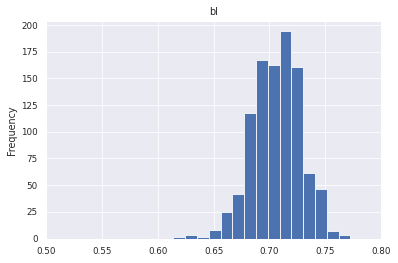

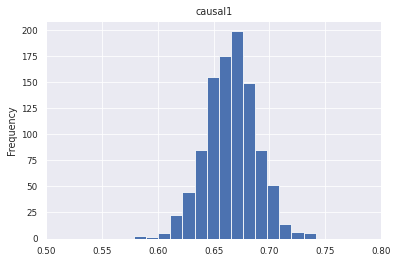

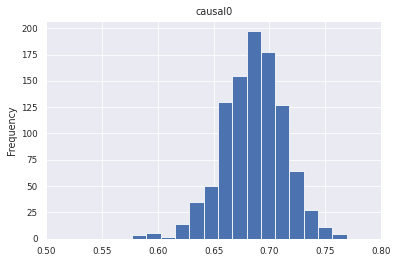

In [7]:
df = pd.read_csv("../MLpipelines/results/holdout-posthoc-cc2-permuted_run.csv")
for cat, dfi in df.groupby('h5cat', sort=False):
    ax = dfi.holdout_score.plot.hist(bins=15, title=cat)
    ax.set_xlim([.50,.80])
    plt.show()

In [10]:
# df